Importing appropriate libraries

In [96]:
import pandas as pd
import numpy as np
import re
import nltk
from ast import literal_eval
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Helper Functions

In [97]:
# Returns the corresponding label given the dataset age category
def standardised_age(ageCagtegory):
    return certs_map[ageCagtegory]

In [98]:
# Preprocesses dataset description into BoW, then applies TF-IDF and SVD to reduce dimensionality
def description_to_svd(dataset):

    # Create input parameters for text_process
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    descriptions = dataset["description"]

    # text preprocess into BoW

    # Loop through each description, preprocess, and append the output to cleaned_reviews
    cleaned_descriptions_lemma = []
    for i, description in enumerate(descriptions):
        cleaned_descriptions_lemma.append(text_preprocess_lemma(description, stop_words, lemmatizer))
    
    # BoW encoding    
    vectorizer_lemma = CountVectorizer()
    description_bow_lemma = vectorizer_lemma.fit_transform(cleaned_descriptions_lemma)

    # BoW to TF-IDF
    tf_idf_transformer = TfidfTransformer()
    description_tfidf_lemma = tf_idf_transformer.fit_transform(description_bow_lemma)

    # TF-IDF to SVD matrix
    svd = TruncatedSVD(n_components=3)
    description_svd = svd.fit_transform(description_tfidf_lemma)

    explained_var = svd.explained_variance_ratio_

    print(f"Variance explained by each SVD component: {explained_var}")   
    print(f"Total variance explained: {explained_var.sum():.4f}")

    return description_svd

def text_preprocess_lemma(doc, stop_words, lemmatizer):
    doc = doc.lower()
    doc = re.sub(r'\.(?=\w)','. ', doc)  # Add a space after fullstop without a space
    doc = re.sub(r'[^A-Za-z\s]', ' ', doc)
    doc = re.sub(r'\s+', ' ', doc) 
    tokens = nltk.word_tokenize(doc)
    tokens = [w for w in tokens if not w in stop_words]
    lemmatized = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(lemmatized)

In [99]:
# Graphs the 3D-svd matrix
def graph_svd(description_svd):
    plt.rcParams["figure.figsize"] = (10, 15)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract the three components of the SVD representation
    x = description_svd[:, 0]
    y = description_svd[:, 1]
    z = description_svd[:, 2]

    # Add data points to the scatterplot
    ax.scatter(x, y, z, c='b', marker='o', label='Movie Descriptions', s=3)

    # Set labels for the axes
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    # Set the title and legend
    plt.title('SVD Representation of Movie Descriptions')
    plt.legend(loc='upper right')
    plt.tight_layout()

    # Show the plot
    plt.savefig("svd_matrix.png")
    plt.show()

In [100]:
# Preprocesses for model 2
def model2_preprocess(dataset, train):
    # Model 2
    model2_col = ["age_certification","genres", "production_countries", "release_year", "type", "person_id"]
    #model2_col = ["age_certification","genres", "production_countries", "release_year", "type"]


    # FOR DIRECTORS, tit_known_dir
    model2Data = dataset[model2_col]
    

    #  Type -----------
    type_list = train['type'].tolist()
    type_list = list(set(type_list))

    for i in type_list:
        model2Data[i] = 0
        model2Data[i] = model2Data['type'].apply(lambda x: int(i == x))

    # genre ----------------------
    genre_strings = train['genres'].tolist()
    genre_list = []

    for i in genre_strings:
        wordList = literal_eval(i)
        for word in wordList:
            genre_list.append(word)

    genre_list = list(set(genre_list))

    for genre in genre_list:
        model2Data[genre] = 0
        model2Data[genre] = model2Data['genres'].apply(lambda x: int(genre in literal_eval(x)))

    # Country --------------------

    country_strings = train['production_countries'].tolist()
    country_list = []
    for i in country_strings:
        CountryList = literal_eval(i)
        for country in CountryList:
            country_list.append(country)
    country_list = list(set(country_list))

    for country in country_list:
        model2Data[country] = 0
        model2Data[country] = model2Data['production_countries'].apply(lambda x: int(country in literal_eval(x)))


    # Director name -----------
    director_list = train['person_id'].tolist()
    director_list = list(set(director_list))
    director_list= [str(x) for x in director_list] # Column names must be str for PCA Calc

    for director in director_list:
        model2Data[director] = 0
        model2Data[director] = model2Data['person_id'].apply(lambda x: int(director == x))


    model2Data = model2Data.drop("genres", axis=1)
    model2Data = model2Data.drop("production_countries", axis=1)
    model2Data = model2Data.drop("type", axis=1)
    model2Data = model2Data.drop("person_id", axis=1)
    model2Data = model2Data.drop("age_certification", axis=1)


    return model2Data


In [101]:
# Determine variance explained by each PCA component
def pca_calc (X):
    sklearn_pca = PCA(n_components=3)
    X_pca = sklearn_pca.fit_transform(X)

    explained_var = sklearn_pca.explained_variance_ratio_
    print(f"Variance explained by each PC: {explained_var}")   
    print(f"Total variance explained: {explained_var.sum():.4f}")   
    
    return X_pca

In [102]:
# Plot the components
def plot_PCA(X,fileName):
    sklearn_pca = PCA(n_components=5)
    X_pca = sklearn_pca.fit_transform(X)

    # To plot Variance explaiend by each PC
    e8 = sklearn_pca.explained_variance_ratio_
    c_range = np.arange(1, 6, 1)
    plt.plot(c_range, e8, 'bx-')
    plt.title('Variance explaiend by each Principle Component')
    plt.xlabel('Component')
    plt.ylabel('Variance explaiend')
    plt.xticks(c_range)  # Use k_range as the x-axis tick values
    plt.savefig(fileName+".png")
    plt.show()



Start ---------- Read in our datasets -----------

In [103]:
credits = pd.read_csv("credits.csv") # 77801 rows

titles = pd.read_csv("titles.csv") # 5850 rows
print(credits.shape)
print(titles.shape)

(77801, 5)
(5850, 15)


In [104]:
# Code for Raw data analysis
at = credits.loc[credits["role"].str.contains('ACTOR'), "name"]
print(len(set(at))) # number of actors

di = credits.loc[credits["role"].str.contains('DIRECTOR'), "name"]
print(len(set(di))) # number of actors



# Movies and TV shows
print(len(titles)) # row length
print(titles.shape[1]) # col length

#print(titles.head(3))

51308
3444
5850
15


Processing credits.txt


In [105]:
# Only care about the director names, so remove any actors from credits
credits_director = credits[credits["role"] == "DIRECTOR"]
# Remove "character" "role" for better space efficiency for linkage to titles
credits_director = credits_director[["person_id", "id", "name"]]
# credits_director 4550 rows

Processing titles.txt

In [106]:
# Only want to retain common features to train both models
col_interested = ["description", "genres", "production_countries", "release_year", "type"]
for col_name in col_interested:
    titles[col_name].fillna("Unknown", inplace=True)
titles = titles[(titles[col_interested] != "Unknown").all(axis=1)]

# Data getting treated as a string, so anything with length 2 will be []
# Shouldn't be any important data with length 2 because they all contain at least '[]'
titles = titles[titles['genres'].map(lambda x: len(x) != 2)]
titles = titles[titles['production_countries'].map(lambda x: len(x) != 2)]
titles.reset_index(drop=True, inplace=True)



In [107]:
# Checking which countries have invalid abbreviation in the dataset
country_strings = titles['production_countries'].tolist()
country_list = []
for i in country_strings:
    CountryList = literal_eval(i)
    for country in CountryList:
        country_list.append(country)
        if len(country) !=2:
            print(country)
titles.loc[titles["production_countries"].str.contains('Lebanon'), "production_countries"] = '["LB"]'


Lebanon


In [108]:
# Group the titles with NA age-certs, this becomes our unknown dataset we are trying to predict
titles["age_certification"].fillna("Unknown", inplace=True)
titles_unknown = titles.loc[titles["age_certification"] == "Unknown"]
titles_unknown.to_csv("titles_unknown.csv", index=False)

In [109]:
# Our training/testing dataset will be titles without unknown values
titles_known = titles.loc[titles["age_certification"] != "Unknown"]
titles_known.to_csv("titles_known.csv", index=False)

In [110]:
# Standardising the age_classifications into more general labels based on domain knowedge
def standardised_age(ageCagtegory):
    return certs_map[ageCagtegory]
all_certs = set(titles_known["age_certification"])
# all_certs = {'TV-MA', 'R', 'PG', 'G', 'TV-Y7', 'TV-G', 'TV-14', 'PG-13', 'TV-Y', 'TV-PG', 'NC-17'}

certs_map = {'R': 'R', 'G': 'G', 'NC-17': 'R', 'PG-13': 'PG', 'TV-14': 'PG', 'TV-Y7': 'PG', 
                'TV-Y': 'G', 'TV-MA': 'MA', 'TV-G': 'G', 'PG': 'PG', 'TV-PG': 'PG', 'MA': 'MA'}

# Standardise the age_certs in titles_known
titles_known["age_certification"] = titles_known["age_certification"].apply(standardised_age)
titles_known = titles_known.reset_index(drop=True)


In [111]:
# Now that we have standardised the age_certs, link the dataset to credits
tit_known_dir = pd.merge(titles_known, credits_director, on=['id'])
tit_unknown_dir = pd.merge(titles_unknown, credits_director, on=['id'])
tit_known_dir.to_csv("tit_known_dir.csv", index=False)
tit_unknown_dir.to_csv("tit_unknown_dir.csv", index=False)

In [112]:
# Spliting Training/Validation and Test Data
TV_data, Test_data = train_test_split(tit_known_dir, test_size=0.2, random_state=42)
print(TV_data.shape) # Number of rows in Training dagtaset
print(tit_known_dir.shape) # Number of rows in our tit_known_dir dataset
print(Test_data.shape) # Number of rows in our Testing dataset


# Finding number of directors in our training dataset
director_list = TV_data['person_id'].tolist()
unqiue_drictor = set(director_list)
print("number of directors in our training dataset")
print(len(unqiue_drictor))


# Finding number of directors in both of our training & testing dataset
test_dic_list = Test_data['person_id'].tolist()
unqiue_test_drictor = set(test_dic_list)
print("directors in both train&test dataset")
print(len(unqiue_drictor & unqiue_test_drictor))


# Finding max and min year in our train
print("max and min year in our training dataset")
print(TV_data['release_year'].max())
print(TV_data['release_year'].min())

(1576, 17)
(1970, 17)
(394, 17)
number of directors in our training dataset
1355
directors in both train&test dataset
84
max and min year in our training dataset
2022
1966


----------------- Model 1  ----------------

In [113]:
print(tit_known_dir.shape)

(1970, 17)


In [114]:
# Cross validation using n=10 folds to evaluate our data, classify using RandomForestClassifier

# Define features (X) and labels (y)
# Using description to predict age certification
X = tit_known_dir["description"]
# Convert X to df because it is a series currently
X = X.to_frame(name="description")
y = tit_known_dir["age_certification"]

# Initialize KFold with the desired number of splits (e.g., 10)
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
accuracy_scores = []
classification_reports = []
confusion_matrices = []

# Perform k-fold cross-validation
# Since doing 10 folds, 90% will be train, 10% test
for train_indices, test_indices in kf.split(X):
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    # Preprocess the data using description_to_svd function
    X_train_svd = description_to_svd(X_train)
    X_test_svd = description_to_svd(X_test)

    # Graphing our 3D svd-matrix
    # graph_svd(X_train_svd)

    # Create and train the classifier
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train_svd, y_train)

    # Make predictions on the test data
    y_pred = classifier.predict(X_test_svd)

    # Calculate and store accuracy for this fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Calculate and store classification report for this fold
    report = classification_report(y_test, y_pred, output_dict=False)
    # report = classification_report(y_test, y_pred, output_dict=True)
    # report = {"G": report["G"], "PG": report["G"], "MA": report["MA"], "R": report["R"], 
    #             "accuracy": report["accuracy"], "macro avg": report["macro avg"], "weighted avg": report["weighted avg"]}
    # report = pd.DataFrame.from_dict(report)
    classification_reports.append(report)

    # Calculate and store confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Print accuracy scores for each fold
# for fold, accuracy in enumerate(accuracy_scores, start=1):
#     print(f"Fold {fold} Accuracy: {accuracy:.2f}")

# Print classification reports for each fold
for fold, report in enumerate(classification_reports, start=1):
    print(f"Fold {fold} Classification Report:")
    print(report)

# Print confusion matrices for each fold
# for fold, cm in enumerate(confusion_matrices, start=1):
#     print(f"Fold {fold} Confusion Matrix:")
#     print(cm)

# for fold, (train_indices, test_indices) in enumerate(kf.split(X), start=1):
#     train_size = len(train_indices)
#     test_size = len(test_indices)
#     print(f"Fold {fold}: Train size = {train_size}, Test size = {test_size}")

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(accuracy_scores)
print(f"Mean Accuracy: {mean_accuracy:.2f}")


Variance explained by each SVD component: [0.00170071 0.00417935 0.00391901]
Total variance explained: 0.0098
Variance explained by each SVD component: [0.00270992 0.01161288 0.00986421]
Total variance explained: 0.0242
Variance explained by each SVD component: [0.00166458 0.00440511 0.00390381]
Total variance explained: 0.0100
Variance explained by each SVD component: [0.00429179 0.01143876 0.01076298]
Total variance explained: 0.0265
Variance explained by each SVD component: [0.00167664 0.00457632 0.00393118]
Total variance explained: 0.0102
Variance explained by each SVD component: [0.003029   0.01064441 0.01034001]
Total variance explained: 0.0240
Variance explained by each SVD component: [0.00170169 0.0047053  0.00387709]
Total variance explained: 0.0103
Variance explained by each SVD component: [0.00279969 0.01120236 0.01032453]
Total variance explained: 0.0243
Variance explained by each SVD component: [0.00169538 0.00474139 0.00430954]
Total variance explained: 0.0107
Variance e

In [115]:
ave_cm = np.zeros_like(confusion_matrices[0])
for cm in confusion_matrices:
    ave_cm += cm
cm_len = len(confusion_matrices)
ave_cm = ave_cm / cm_len
print(ave_cm)

[[ 0.3  1.5  8.8  2.5]
 [ 0.3  3.4 20.1  5.3]
 [ 1.2 11.4 61.1 21.4]
 [ 0.7  6.4 39.6 13. ]]


In [116]:
# Switch MA and PG column for better visualisation
ave_cm = np.array([
    [0.2, 8.7, 1.4, 2.8],
    [1.1, 64.8, 12.8, 16.4],
    [0.2, 20.6, 4.2, 4.1],
    [0.2, 39.4, 8.1, 12]
])

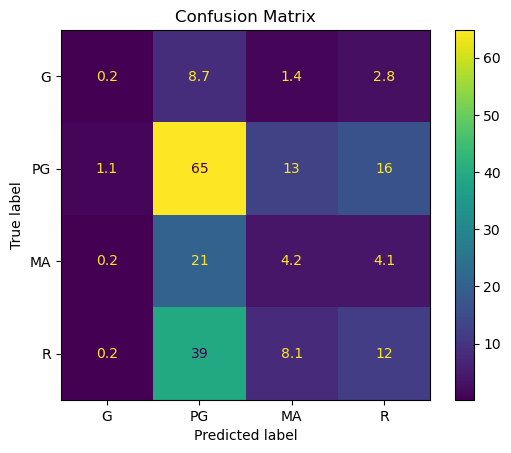

In [117]:
disp = ConfusionMatrixDisplay(confusion_matrix=ave_cm, # pass through the created confusion matrix
                              display_labels=['G', 'PG', 'MA', 'R'] # class labels from the knn model 
                             )
disp.plot()

plt.title("Confusion Matrix")
plt.show()

----------------- Model 2 ----------------

Variance explained by each PC: [0.94283322 0.00791973 0.00689047]
Total variance explained: 0.9576


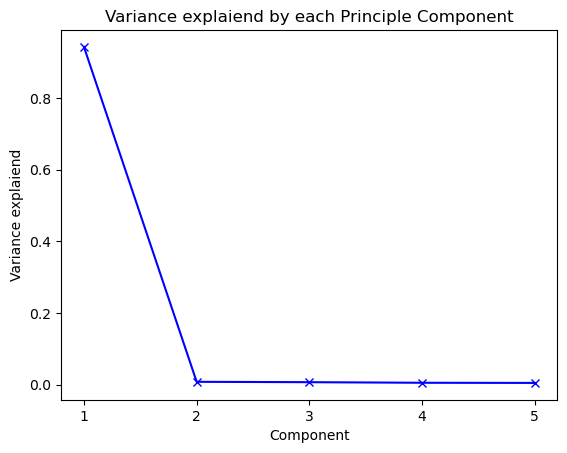

In [118]:
import warnings
warnings.filterwarnings('ignore')

model2_data = model2_preprocess(TV_data,TV_data)
model2_pca = pca_calc(model2_data)
labels = TV_data["age_certification"].to_numpy()

# plot PCA varance explaiend
plot_PCA(model2_data, "model2_PCA_Training")



Variance explained by each PC: [0.94285325 0.0079199  0.00689061]
Total variance explained: 0.9577
Variance explained by each PC: [0.94284323 0.00791981 0.00689054]
Total variance explained: 0.9577
Variance explained by each PC: [0.94285325 0.0079199  0.0068906 ]
Total variance explained: 0.9577
Variance explained by each PC: [0.94285325 0.00791989 0.00689061]
Total variance explained: 0.9577
Variance explained by each PC: [0.94284323 0.00791982 0.00689054]
Total variance explained: 0.9577
Variance explained by each PC: [0.94284323 0.00791981 0.00689054]
Total variance explained: 0.9577
Variance explained by each PC: [0.94285325 0.00791987 0.00689061]
Total variance explained: 0.9577
Variance explained by each PC: [0.94284323 0.0079198  0.00689054]
Total variance explained: 0.9577
Variance explained by each PC: [0.94283322 0.00791973 0.00689047]
Total variance explained: 0.9576
Variance explained by each PC: [0.94284323 0.00791982 0.00689053]
Total variance explained: 0.9577
Variance e

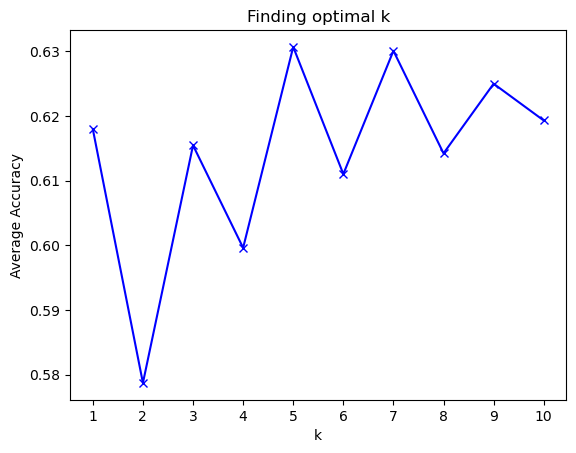

In [119]:
# Using Cross validation to decide the value for k

n = 10
nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)

accuracy_list = []

TV_data_array = TV_data.values

for k in range(1,11):
    results = []
    for train_idx, test_idx in nf_CV.split(TV_data_array):
        
        # train-test split
        X_train = TV_data.iloc[train_idx]  # Create a DataFrame for X_train
        X_test = TV_data.iloc[test_idx] 
        y_train, y_test = labels[train_idx], labels[test_idx]
        

        model2_data = model2_preprocess(TV_data,X_train)
        model2_pca = pca_calc(model2_data)
        X_train, X_test = model2_pca[train_idx], model2_pca[test_idx]


        # Preprocessing
        # 1. Standardise the data
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        # Training
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)    
        
        # Predictions
        y_pred = knn.predict(X_test)
        results.append(accuracy_score(y_test, y_pred))

    accuracy_list.append(np.mean(results))


k_range = np.arange(1, 11, 1)

plt.plot(k_range, accuracy_list, 'bx-')
plt.title('Finding optimal k')
plt.xlabel('k')
plt.ylabel('Average Accuracy')
plt.xticks(k_range)  # Use k_range as the x-axis tick values
plt.savefig("model2_avg_accuracy.png")
plt.show()

print(accuracy_list)



In [120]:
# Cross validation using n=10 folds to evaluate our data, classify using KNeighborsClassifier

accuracy_scores = []
confusion_matrices = []
full_data_array = tit_known_dir.values
labels = tit_known_dir["age_certification"].to_numpy()
for train_idx, test_idx in nf_CV.split(full_data_array):
    
    # train-test split
    X_train = tit_known_dir.iloc[train_idx]  # Create a DataFrame for X_train
    X_test = tit_known_dir.iloc[test_idx] 
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    model2_data = model2_preprocess(tit_known_dir,X_train)
    model2_pca = pca_calc(model2_data)
    X_train, X_test = model2_pca[train_idx], model2_pca[test_idx]



    # 1. Standardise the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Training
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
        

    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    accuracy_scores.append(accuracy)

    print(f"Accuracy: {accuracy:.2f}")
    print(report)
    print(cm)

ave_ac = 0
for acc in accuracy_scores:
    ave_ac += acc
ave_ac = ave_ac / 10
print("ave accuracy", ave_ac)


Variance explained by each PC: [0.94112277 0.00813696 0.00706844]
Total variance explained: 0.9563
Accuracy: 0.59
              precision    recall  f1-score   support

           G       0.33      0.13      0.19        15
          MA       0.63      0.90      0.75        21
          PG       0.62      0.58      0.60       103
           R       0.55      0.62      0.59        58

    accuracy                           0.59       197
   macro avg       0.54      0.56      0.53       197
weighted avg       0.58      0.59      0.58       197

[[ 2  0 13  0]
 [ 0 19  2  0]
 [ 3 11 60 29]
 [ 1  0 21 36]]
Variance explained by each PC: [0.9411392  0.00813709 0.00706856]
Total variance explained: 0.9563
Accuracy: 0.65
              precision    recall  f1-score   support

           G       0.38      0.30      0.33        10
          MA       0.64      0.70      0.67        23
          PG       0.69      0.69      0.69       102
           R       0.65      0.65      0.65        62

    

In [121]:
ave_cm = np.zeros_like(confusion_matrices[0])
for cm in confusion_matrices:
    ave_cm += cm
cm_len = len(confusion_matrices)
ave_cm = ave_cm / cm_len
print(type(ave_cm))

<class 'numpy.ndarray'>


In [122]:
# Switch MA and PG column for better visualisation
ave_cm = np.array([
    [2.9, 8.6, 0.6, 1.0],
    [4.5, 61.3, 8.8, 20.5],
    [0.2, 6.1, 22.8, 0.0],
    [1.1, 19.0, 0.0, 39.6]
])

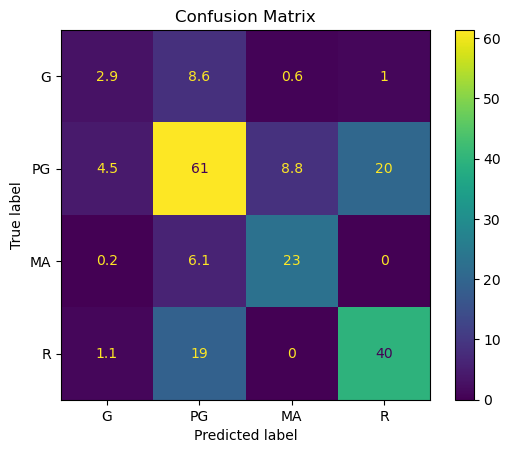

In [123]:
disp = ConfusionMatrixDisplay(confusion_matrix=ave_cm, # pass through the created confusion matrix
                              display_labels=['G', 'PG', 'MA', 'R'] # class labels from the knn model 
                             )

disp.plot()

plt.title("Confusion Matrix")
plt.show()

In [124]:
print(tit_known_dir['age_certification'].value_counts()['G'])
print(TV_data['age_certification'].value_counts()['G'])

131
106
